## Create and test ion channel model

In [21]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_inact_kin_100,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

from experiments.ina_schneider import (schneider_iv,
                                    schneider_tauf,
                                    schneider_taum,
                                    schneider_taus,
                                      schneider_inact,
                                       schneider_inact_128,
                                      schneider_reduc,
                                       schneider_reduc_95,
                                      schneider_recov,
                                      schneider_recov_95)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

In [22]:
modelfile = 'models/nygren_Na.mmt'

In [23]:
observations, model, summary_statistics = setup(modelfile,
                                                schneider_iv,
                                                schneider_inact_128,
                                                schneider_recov_95
                                                )
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [24]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 
# 

limits = {'ina.P_Na' : (0.000001,0.05),
          'ina.s1' : (0,1),
          'ina.q1': (80,120),
          'ina.q2': (-20,20),
          'ina.r1': (25,75),
          'ina.r2': (-25,25),
          'ina.q3': (20,40),
          'ina.q4': (20,80),
          'ina.q5': (-25,25),
          'ina.q6': (10,40),
          'ina.q7': (0,40),
          'ina.q8': (0,40),
          'ina.r3': (0,1),
          'ina.r4': (0,100),
          'ina.r5': (0,100),
          'ina.r6': (0,0.01)}

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [25]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_ina_testing.db"))

In [7]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [8]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [9]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5559635983872266, '1': 1.5559635983872266, '2': 1.5559635983872266, '3': 0.9264723646571446, '4': 0.2930237457039254, '5': 0.2593272663978711, '6': 0.291681427647259, '7': 0.3714290292593773, '8': 0.4877918848914798, '9': 0.9685247788996385, '10': 1.5559635983872266, '11': 1.227103272518006, '12': 0.5887786804376165, '13': 0.3853198365246076, '14': 0.29778536789736504, '15': 0.9335781590323361, '16': 0.9335781590323361, '17': 0.9335781590323361, '18': 0.9335781590323361, '19': 0.9335781590323361, '20': 0.9335781590323361, '21': 0.9335781590323361, '22': 0.9335781590323361, '23': 0.9335781590323361, '24': 0.9335781590323361, '25': 0.9335781590323361, '26': 0.9335781590323361, '27': 0.9335781590323361, '28': 0.9335781590323361, '29': 0.9335781590323361, '30': 0.9335781590323361, '31': 0.9335781590323361, '32': 0.9335781590323361, '33': 0.9335781590323361, '34': 0.9335781590323361, '35': 0.9335781590323361, '36': 0.9335781590323361, '37': 0.933578159

In [10]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [11]:
#abc.load(db_path,60)

In [12]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=69, start_time=2019-09-13 06:11:46.125916, end_time=None)>


In [15]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0)

INFO:ABC:t:10 eps:1.2375759555977426
DEBUG:ABC:now submitting population 10
DEBUG:ABC:population 10 done
DEBUG:ABC:
total nr simulations up to t =10 is 149306
DEBUG:Epsilon:new eps, t=11, eps=1.1719138058391185
INFO:ABC:t:11 eps:1.1719138058391185
DEBUG:ABC:now submitting population 11
DEBUG:ABC:population 11 done
DEBUG:ABC:
total nr simulations up to t =11 is 164725
DEBUG:Epsilon:new eps, t=12, eps=1.1214695751915569
INFO:ABC:t:12 eps:1.1214695751915569
DEBUG:ABC:now submitting population 12
DEBUG:ABC:population 12 done
DEBUG:ABC:
total nr simulations up to t =12 is 180271
DEBUG:Epsilon:new eps, t=13, eps=1.0849224258198666
INFO:ABC:t:13 eps:1.0849224258198666
DEBUG:ABC:now submitting population 13
DEBUG:ABC:population 13 done
DEBUG:ABC:
total nr simulations up to t =13 is 196845
DEBUG:Epsilon:new eps, t=14, eps=1.0530322004921224
INFO:ABC:t:14 eps:1.0530322004921224
DEBUG:ABC:now submitting population 14
DEBUG:ABC:population 14 done
DEBUG:ABC:
total nr simulations up to t =14 is 2138

# Results analysis

In [59]:
#history.all_runs()

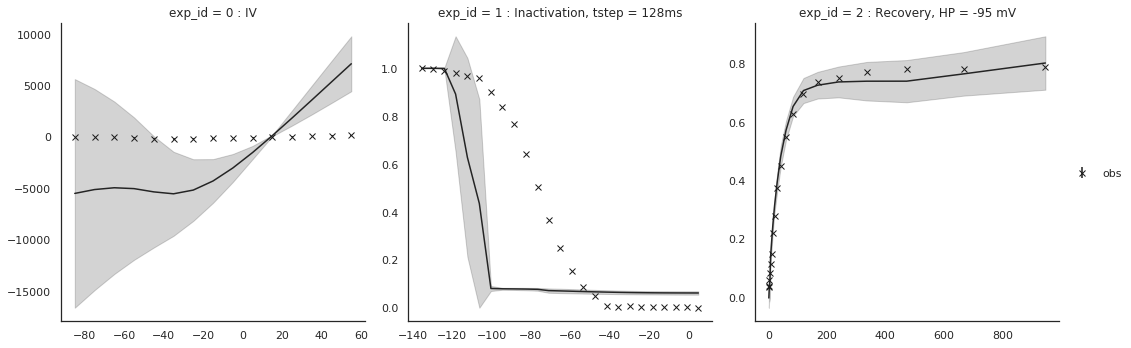

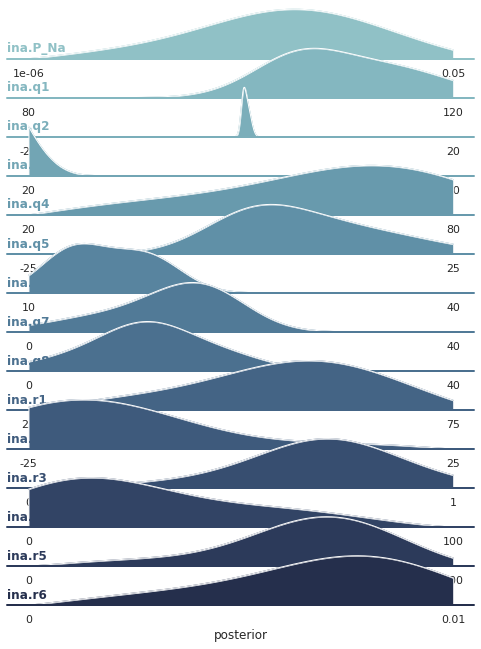

In [42]:
history = History(db_path)
history.id = 64

#Sakakibara experiments :


# time constants corresponds to sakakibara_inact_kin_1
# recovery HP = -100 mv corresponds to sakakibara_recov_100
# availablity HP = -100 mv corresponds to sakakibara_inact_kin_100
# availablity HP = -80 mv corresponds to sakakibara_inact_kin_80
# all experiments corresponds to sakakibara_iv,sakakibara_act,sakakibara_inact,sakakibara_inact_kin_1


# history.id correspondance :

# 54 corresponds to the availability HP = -80 mV with 30 iterations : fail
# 56 corresponds to time constants : success
# 57 corresponds to the availability HP -100 mV : 30 iter and eps = 2.37 : fail
# 58 corresponds to the recovery HP -100 mV : fail
# 60 corresponds to all experiments. eps = 0.75 with 22 iter : success

# 65 corresponds to the recovery HP -100 mV : with mS 0.001 in the mmt file eps = 0.54, iter = 27
# seems to be way better than before : the next step would be to try the recovery with another HP to confirm
# the result (since it's contradictory with 58)


# Schneider experiments:


# IV corresponds to schneider_iv,
# inact corresponds to schneider_inact_128
# availability corresponds to schneider_reduc_95
# recovery corresponds to schneider_recov_95
# all experiment corresponds to schneider_iv,schneider_inact_128,schneider_recov_95


# history.id correspondance :

# 61 corresponds to IV + inact : success : eps = 0.43 (18 iter)
# 62 corresponds to availability : fail : eps = 4.1 (10 iter)
# 64 corresponds to recovery : success : eps = 0.29 (25 iter) : notice that q2 is close to 0 
# (physically not coherent)

# 66 corresponds to the all experiments : eps = 1.37, iter = 23 : recovery fails, probably because q2 =! 0

df, w = history.get_distribution(m=0)
#df.describe()
grid1 = plot_sim_results(modelfile,schneider_iv,
                         schneider_inact_128,
                         schneider_recov_95,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)